# This is the demo of TAC-GAN on MOG (mixture of gaussian) 

Load the needed package

# Import and libraries

In [1]:
%matplotlib inline
import os
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from mmd_metric import polynomial_mmd

# Classes for cGAN

In [2]:
#######G network

class G_guassian(nn.Module):

    def __init__(self, nz,num_classes=2):
        super(G_guassian, self).__init__()


        self.embed = nn.Embedding(num_embeddings=num_classes, embedding_dim=nz)

        self.decode = nn.Sequential(

            nn.Linear(nz*2,10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            # nn.Tanh(),
            nn.Linear(10, 1),
        )

        self.__initialize_weights()

    def forward(self, z, label, output=None):

        input = torch.cat([z,self.embed(label)],dim=1)
        x = input.view(input.size(0), -1)
        output = self.decode(x)

        return output

    def __initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)
                

#####D network
class D_guassian(nn.Module):

    def __init__(self, num_classes=10,AC=True):
        super(D_guassian, self).__init__()

        self.AC = AC

        self.encode = nn.Sequential(

            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            # nn.Tanh(),
        )
        self.gan_linear = nn.Linear(10, 1)
        self.aux_linear = nn.Linear(10, num_classes)
        self.mi_linear = nn.Linear(10, num_classes)

        if not self.AC:
            self.projection = nn.Embedding(num_embeddings=num_classes,embedding_dim=10)

        self.sigmoid = nn.Sigmoid()
        self.__initialize_weights()

    def forward(self, input,y=None):

        x = self.encode(input)
        x = x.view(-1, 10)
        c = self.aux_linear(x)
        mi = self.mi_linear(x)

        s = self.gan_linear(x)
        if not self.AC:
            s += (self.projection(y)*x).sum(dim=1,keepdim=True)
        s = self.sigmoid(s)
        return s.squeeze(1), c.squeeze(1), mi.squeeze(1)

    def __initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)

# Helper functions to plot the results

In [4]:
def plot_density(flights,binwidth=0.1):
    ax = plt.subplot(1,1,1)

    # Draw the plot
    ax.hist(flights, bins=int(180 / binwidth),
            color='blue', edgecolor='black')

    # Title and labels
    ax.set_title('Histogram with Binwidth = %d' % binwidth, size=30)
    ax.set_xlabel('Delay (min)', size=22)
    ax.set_ylabel('Flights', size=22)

    plt.tight_layout()
    plt.show()

# Runner

In [3]:
####TAC-GAN: set AC=True, MI=True, AC-GAN:set AC=True, MI=False, Projection-GAN: set AC=False, MI=False
def train(data1,data2,data3,nz,G,D,optd,optg,AC=True,MI=True):
    for _ in range(20):
        for i in range(1000):

            #####D step
            for _ in range(1):
                data = torch.cat(
                    [data1[128 * i:128 * i + 128], data2[128 * i:128 * i + 128], data3[128 * i:128 * i + 128]],
                    dim=0).unsqueeze(dim=1)
                label = torch.cat([torch.ones(128).cuda().long()*0, torch.ones(128).cuda().long()*1, torch.ones(128).cuda().long()*2],dim=0)

                ###D
                d_real, c, _ = D(data)

                z = torch.randn(256, nz).cuda()
                fake_label = torch.LongTensor(256).random_(3).cuda()
                fake_data = G(z, label=fake_label)
                d_fake, _, mi = D(fake_data)


                D_loss = F.binary_cross_entropy(d_real, torch.ones(384).cuda()) \
                         + F.binary_cross_entropy(d_fake, torch.zeros(256).cuda())
                if AC:
                    D_loss += F.cross_entropy(c, label)
                if MI:
                    D_loss += F.cross_entropy(mi, fake_label)

                optd.zero_grad()
                D_loss.backward()
                optd.step()

            #####G step
            if i % 10 == 0:
                z = torch.randn(256, nz).cuda()
                fake_label = torch.LongTensor(256).random_(3).cuda()
                fake_data = G(z, label=fake_label)
                d_fake, c, mi = D(fake_data)

                G_loss = F.binary_cross_entropy(d_fake, torch.ones(256).cuda())

                if AC:
                    G_loss += F.cross_entropy(c,fake_label)
                if MI:
                    G_loss -= F.cross_entropy(mi, fake_label)

                optg.zero_grad()
                G_loss.backward()
                optg.step()

# Visualize and evaluation

Running the 1-D MOG toy experiments of different distance between different gaussian components. Cost about 10 min in 1080ti

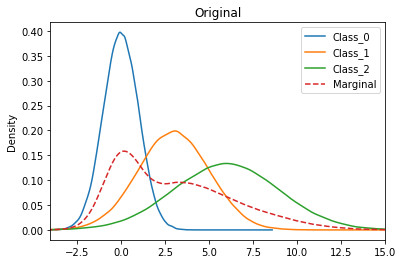

In [12]:

######create folder to save the result
distance = 3
if os.path.exists(os.path.join('MOG','1D', str(distance) + '_1D')):
    pass
else:
    os.makedirs(os.path.join('MOG','1D', str(distance) + '_1D'))
save_path = os.path.join('MOG','1D', str(distance) + '_1D')

######Generate MOG data of different mean and variance
data1 = torch.randn(128000).cuda()
data2 = torch.randn(128000).cuda() * 2 + distance
data3 = torch.randn(128000).cuda() * 3 + distance * 2

df1 = pd.DataFrame()
df2 = pd.DataFrame()

df1['score_{0}'.format(0)] = data1.cpu().numpy()
df1['score_{0}'.format(1)] = data2.cpu().numpy()
df1['score_{0}'.format(2)] = data3.cpu().numpy()
r_data = torch.cat([data1, data2, data3], dim=0).cpu().numpy()
df2['score_{0}'.format(2)] = r_data
np.save(save_path+'/o_data',r_data)

######Plot the distribution of original data
fig, ax = plt.subplots(1, 1)
for s in df1.columns:
    df1[s].plot(kind='kde')

for s in df2.columns:
    df2[s].plot(style='--',kind='kde')
plt.xlim((-4, 9 + distance * 2))
ax.legend(["Class_0", "Class_1","Class_2","Marginal"])
plt.title('Original')
fig.savefig(save_path + '/original.eps')

# Build Network

In [13]:
####TAC-GAN: set AC=True, MI=True, AC-GAN:set AC=True, MI=False, Projection-GAN: set AC=False, MI=False
##Default TAC-GAN
AC = True
MI = True
if AC:
    if MI:
        name = 'TAC'
    else:
        name = 'AC'
else:
    name = 'Projection'
            
        
#####Bulding network
nz = 2
G = G_guassian(nz=nz, num_classes=3).cuda()

D = D_guassian(num_classes=3,AC=AC).cuda()

optg = optim.Adam(G.parameters(), lr=0.002,
                      betas=(0.5, 0.999))
optd = optim.Adam(D.parameters(), lr=0.002,
                      betas=(0.5, 0.999))

In [4]:
#####Train network
train(data1,data2,data3,nz,G,D,optd,optg,AC=AC,MI=MI)
print('Training finished')

#####Sample data from Generator
z = torch.randn(10000, nz).cuda()
label = torch.zeros(10000).long().cuda()  # torch.LongTensor(10000).random_(2).cuda()#
data1_g = G(z=z, label=label).squeeze().cpu().detach()

z = torch.randn(10000, nz).cuda()
label = torch.ones(10000).long().cuda()  # torch.LongTensor(10000).random_(2).cuda()#
data2_g = G(z=z, label=label).squeeze().cpu().detach()

z = torch.randn(10000, nz).cuda()
label = torch.ones(10000).long().cuda() + 1  # torch.LongTensor(10000).random_(2).cuda()#
data3_g = G(z=z, label=label).squeeze().cpu().detach()

df1 = pd.DataFrame()
df2 = pd.DataFrame()

df1['score_{0}'.format(0)] = data1_g.numpy()
df1['score_{0}'.format(1)] = data2_g.numpy()
df1['score_{0}'.format(2)] = data3_g.numpy()
g_data = torch.cat([data1_g, data2_g, data3_g], dim=0).numpy()
df2['score_{0}'.format(2)] = g_data

#####Plot generated conditional distribution
fig, ax = plt.subplots(1, 1)
for s in df1.columns:
    df1[s].plot(kind='kde')

for s in df2.columns:
    df2[s].plot(style='--',kind='kde')

plt.xlim((-4, 9 + distance * 2))
ax.legend(["Class_0", "Class_1", "Class_2", "Marginal"])
plt.title(name)
fig.savefig(save_path + '/'+name+'.eps')

NameError: name 'data1' is not defined

# Evaluate the MMD distance between true data and generated data

In [15]:

mean0_0,var0_0 = polynomial_mmd(np.expand_dims(data1_g.numpy(), axis=1), np.expand_dims(data1.cpu().numpy(),axis=1))
mean0_1, var0_1 = polynomial_mmd(np.expand_dims(data2_g.numpy(), axis=1),
                                     np.expand_dims(data2.cpu().numpy(), axis=1))
mean0_2, var0_2 = polynomial_mmd(np.expand_dims(data3_g.numpy(), axis=1),
                                     np.expand_dims(data3.cpu().numpy(), axis=1))
mean0, var0 = polynomial_mmd(np.expand_dims(g_data, axis=1), np.expand_dims(r_data, axis=1))
print('the distance of class 0 is : ', mean0_0)
print('the distance of class 1 is : ', mean0_1)
print('the distance of class 2 is : ', mean0_2)
print('the distance of marginal is : ', mean0)

the distance of class 0 is :  0.008205491237123663
the distance of class 1 is :  1.5177659917671917
the distance of class 2 is :  0.781029228938678
the distance of marginal is :  -0.11618767918389494
